In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
# Import necessary modules
import pandas as pd
import ast
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
# Define important variables
songs = ["diggin", "americano", "jagger", "pink"] 

participants = ["part1", "part2", "part3", "part4"]

joints = {"nose": [], "left eye (inner)": [], "left eye": [], "left eye (outer)": [], "right eye (inner)": [], "right eye": [], 
          "right eye (outer)": [], "left ear": [], "right ear": [], "mouth (left)": [], "mouth (right)": [], "left shoulder": [], 
          "right shoulder": [], "left elbow": [], "right elbow": [], "left wrist": [], "right wrist": [], "left pinky": [],
          "right pinky": [], "left index": [], "right index": [], "left thumb": [], "right thumb": [], "left hip": [], "right hip": [], 
          "left knee": [], "right knee": [], "left ankle": [], "right ankle": [], "left heel": [], "right heel": [], "left foot index": [], 
          "right foot index": []}

c = {}
for j in joints.keys():
  c[j] = ast.literal_eval

score_dic = {"X":0, "PERFECT":1, "GOOD":3, "OK":4, "YEAH":5}

In [ ]:
from operator import length_hint
Xd = {} # this will hold all the input data
for col in joints.keys():
  Xd["{}_x".format(col)] = []
  Xd["{}_y".format(col)] = []
yd = {"score": []} # this will hold all the output data

same = False

for participant in participants: # loop over all participants
  for song in songs: # loop over all songs
    
    print("Working on {}, {}".format(participant, song))
    
    try:
      score_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Scores/{}_{}_pred.csv".format(song, participant))
      scores = score_df['score']

      frames_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Dances/{}_frames.csv".format(song))

      sk_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Dances/{}_{}_sk.csv".format(song, participant),  converters = c)
      sk_df = sk_df.rename({'Unnamed: 0': 'frame'}, axis=1)

      baseline_df = pd.read_csv("/content/drive/MyDrive/Thesis/Experiment Dances/{}_baseline_sk.csv".format(song), converters = c)
      baseline_df = baseline_df.rename({'Unnamed: 0': 'frame'}, axis=1)

    except FileNotFoundError:
      print("missing a file for {}, {}".format(song, participant)) 
      continue

    for i in range(frames_df.shape[0]): # loop over all the frames (dance moves)

      # Create timeframe
      start_frame = frames_df['start_frame'][i]
      end_frame = frames_df['end_frame'][i]

      # Extract the dancers skeletal data for the given frame
      sk_sub_df = sk_df[sk_df['frame'] >= start_frame]
      sk_sub_df = sk_sub_df[sk_sub_df['frame'] <= end_frame]

      # Extracht the baseline skeletal data for the given frame
      base_sub_df = baseline_df[baseline_df['frame'] >= start_frame]
      base_sub_df = base_sub_df[base_sub_df['frame'] <= end_frame]

      empty = False

      for col in joints.keys(): 

        all_x = 0
        all_y = 0
        n = 0

        for sk_xy, base_xy in zip(list(sk_sub_df[col]), list(base_sub_df[col])):

          sk_x, sk_y = sk_xy
          base_x, base_y = base_xy

          if sk_x == 0 or sk_y == 0 or base_x == 0 or base_y == 0:
            continue # when the coordinates are 0 no person was detected in the frame

          all_x += abs(sk_x - base_x) 
          all_y += abs(sk_y - base_y)
          n+= 1
          #all_x += (sk_x - base_x)
          #all_y += (sk_y - base_y)
        
        if n > 0:
          # Calculate average 
          av_x = all_x/n
          av_y = all_y/n
          # Add averaged score difference to X
          Xd["{}_x".format(col)].append(av_x)
          Xd["{}_y".format(col)].append(av_y)

        else:
          empty = True

      if empty:        # Whole dance pose is empty
        scores = scores.drop(i) # Remove score from scores

    # Add scores to y
    yd["score"].extend(scores)

In [ ]:
# Convert and check X and y
X = pd.DataFrame(Xd)
y = pd.DataFrame(yd)
#print(X)
print(X.shape)
#print(y)
print(y.shape)

(3106, 66)
(3106, 1)


<Axes: xlabel='Labels', ylabel='Frequency'>

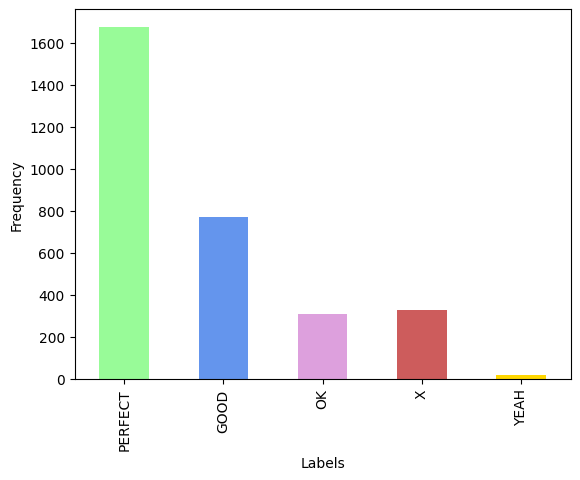

In [ ]:
y['score'].value_counts().loc[['PERFECT', 'GOOD', 'OK', 'X', 'YEAH']].plot.bar(color = ['palegreen', 'cornflowerblue', 'plum', 'indianred', 'gold'], 
                                                                               ylabel = 'Frequency', xlabel = 'Labels')

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y['score']= label_encoder.fit_transform(y['score']) 
y = np.ravel(y)

In [ ]:
label_encoder.classes_

array(['GOOD', 'OK', 'PERFECT', 'X', 'YEAH'], dtype=object)

In [ ]:
accuracies = {}
precisions = {}
recalls = {}
f1_scores = {}

In [ ]:
# Split the data
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.333, shuffle=True, random_state=42)

# KNN Classifier

Find the right value for k:

In [ ]:
# Find the right value for k
k_values = [i for i in range (1,35)]
scores = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_val)
    scores.append(accuracy_score(y_val, y_pred))

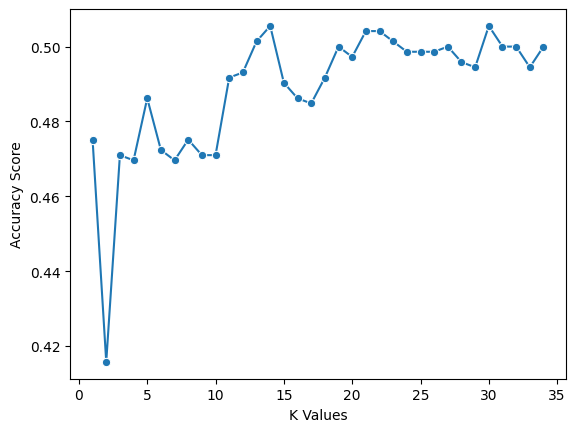

In [ ]:
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/knn_k.png')
plt.show()

Train model with best k and evaluate:

In [ ]:
# Train model with best k and evaluate

best_index = np.argmax(scores)
best_k = k_values[best_index]

knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train, np.ravel(y_train))

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies['K-NN'] = accuracy
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1) 
precisions['K-NN'] = precision
recall = recall_score(y_test, y_pred, average='weighted')
recalls['K-NN'] = recall
f1 = f1_score(y_test, y_pred, average='weighted')
f1_scores['K-NN'] = f1

print("Accuracy for k = {}: {}".format(best_k, accuracy))
print("Precision:", precision)
print("Recall:", recall)
print('F1 score:', f1)

Accuracy for k = 14: 0.5300429184549357
Precision: 0.3990756934294476
Recall: 0.5300429184549357
F1 score: 0.42858744568143287


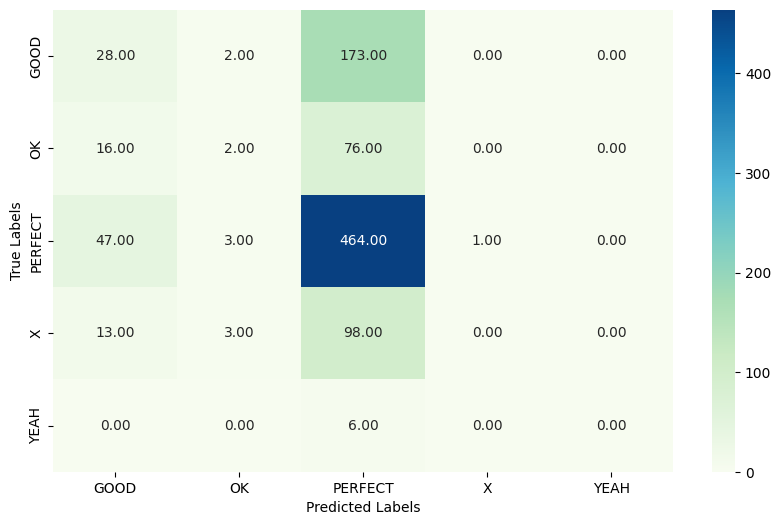

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu", xticklabels = list(label_encoder.classes_), yticklabels = list(label_encoder.classes_))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.savefig('/content/drive/MyDrive/Thesis/Results/knn_conf3.png')
plt.show()

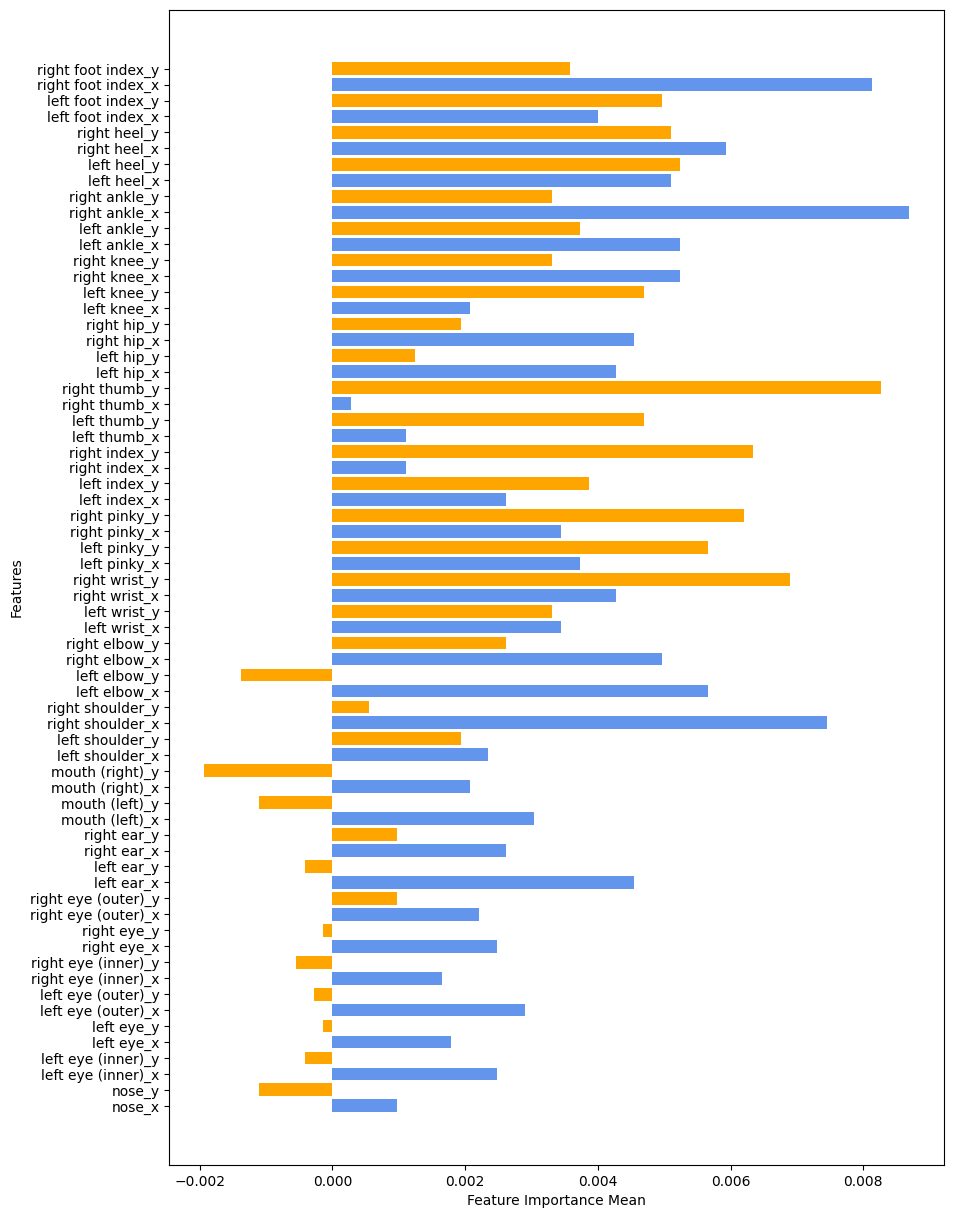

In [ ]:
from sklearn.inspection import permutation_importance

# perform permutation importance
results = permutation_importance(knn, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# plot feature importance
plt.figure(figsize=(10,15))
plt.barh([x for x in range(len(importance))], importance, linewidth=3, color=['cornflowerblue','orange'], tick_label=list(Xd.keys()))
plt.xlabel("Feature Importance Mean")
plt.ylabel("Features")

plt.savefig('/content/drive/MyDrive/Thesis/Results/knn_feat3.png')
plt.show()

# Support Vector Machine

In [ ]:
from sklearn import svm
from sklearn import metrics

Linear SVM

In [ ]:
# Find best hyperparameters

c_list = [0.01, 0.1, 1, 10, 25, 50, 75, 100]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1]
best_acc = 0
best_c = 0
best_gamma = 0

for c in c_list:
  for g in gamma_list:
    clf = svm.SVC(kernel='linear', C = c, gamma=g)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = metrics.accuracy_score(y_val, y_pred)
    if acc > best_acc:
      best_acc = acc
      best_c = c
      best_gamma = g

print("Highest accuracy is {}, for C = {} and gamma = {}".format(best_acc, best_c, best_gamma))

Highest accuracy is 0.5220994475138122, for C = 0.01 and gamma = 0.0001


In [ ]:
# Train SVM model for with best hyperparameters
clf = svm.SVC(kernel='linear', C = best_c, gamma=best_gamma)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies['SVM'] = accuracy
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
precisions['SVM'] = precision
recall = recall_score(y_test, y_pred, average='weighted')
recalls['SVM'] = recall
f1 = f1_score(y_test, y_pred, average='weighted')
f1_scores['SVM'] = f1

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print('F1 score:', f1)

Accuracy: 0.5525751072961373
Precision: 0.7527641419072003
Recall: 0.5525751072961373
F1 score: 0.393332661033187


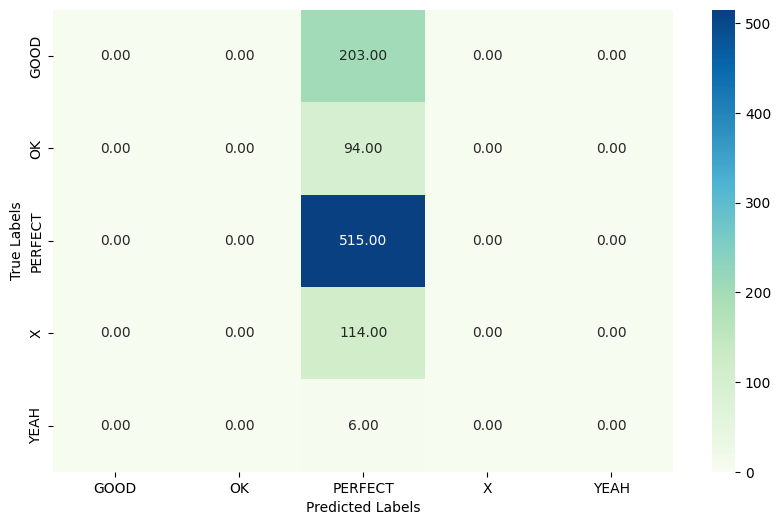

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu", xticklabels = list(label_encoder.classes_), yticklabels = list(label_encoder.classes_))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/svm_conf.png')
plt.show()

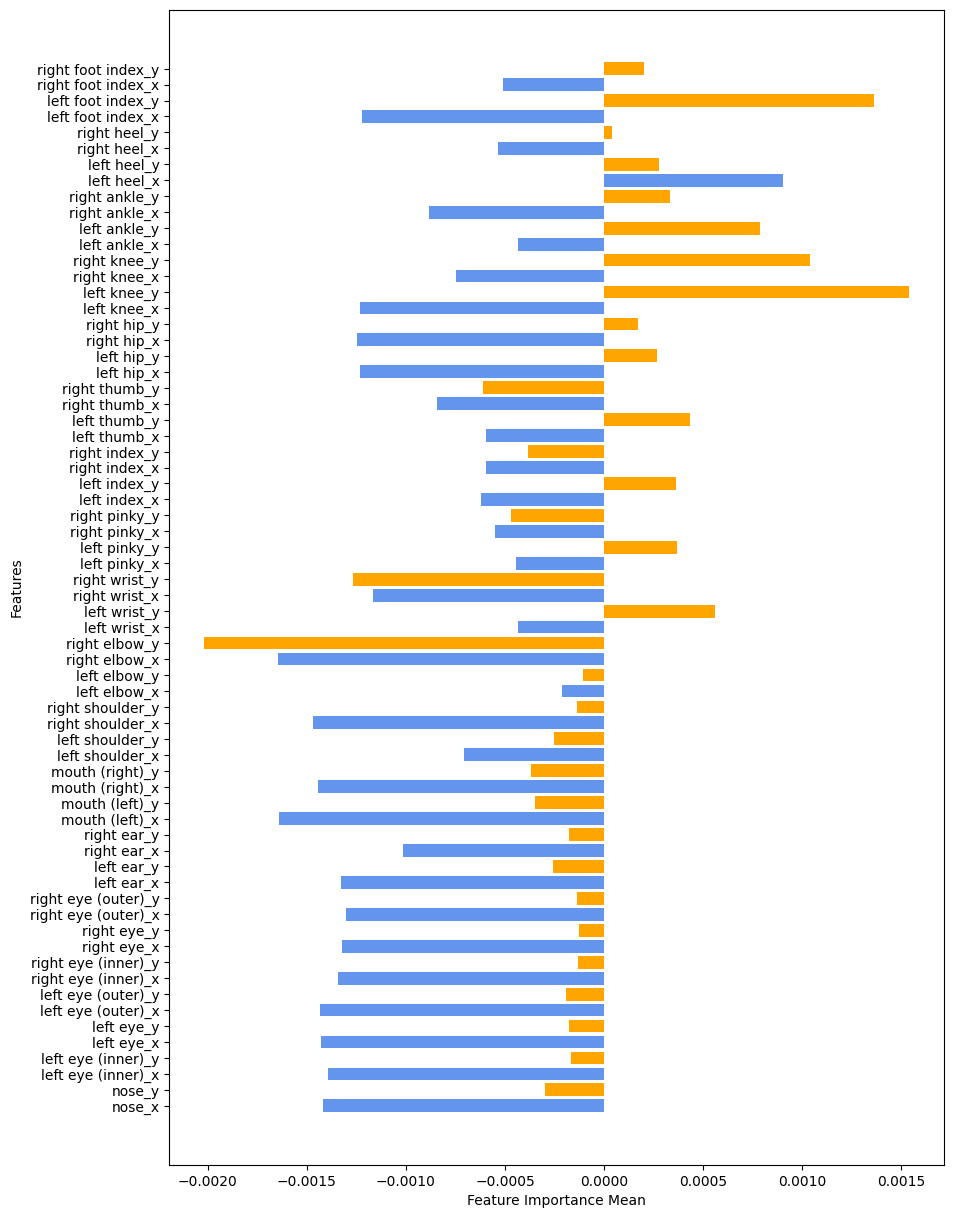

In [ ]:
coefs = clf.coef_
importance = coefs.mean(axis=0)

plt.figure(figsize=(10,15))
plt.barh([x for x in range(len(importance))], importance, linewidth=3, color=['cornflowerblue','orange'], tick_label=list(Xd.keys()))
plt.xlabel("Feature Importance Mean")
plt.ylabel("Features")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/svm_feat.png')
plt.show()

Kernel SVM

# Multi-Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
activation_functs = ['identity', 'logistic', 'tanh', 'relu']
layer_sizes_i = [10, 25, 50, 100, 150]
layer_sizes_j = [1,2,3,4,5]

best_acc = 0
best_func = 0
best_size = (0,0)

for func in activation_functs:
  for i in layer_sizes_i:
    for j in layer_sizes_j:
      mlp = MLPClassifier(activation = func, hidden_layer_sizes=(i,j), random_state=1, max_iter=1000)
      mlp.fit(X_train, y_train)
      y_pred = mlp.predict(X_val)
      acc = metrics.accuracy_score(y_val, y_pred)

      if acc > best_acc:
        best_acc = acc
        best_func = func
        best_size = (i,j)

print("Highest accuracy is {}, for activation function {} and layer size = {}".format(best_acc, best_func, best_size))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Highest accuracy is 0.5386740331491713, for activation function tanh and layer size = (100, 3)


Highest accuracy is 0.5621546961325967, for activation function relu and layer size = (10, 5)

In [ ]:
from sklearn.neural_network import MLPClassifier

best_func = 'tanh'
best_size = (100,3)

mlp = MLPClassifier(activation = best_func, hidden_layer_sizes=best_size, random_state=1, max_iter=1000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracies['MLP'] = accuracy
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
precisions['MLP'] = precision
recall = recall_score(y_test, y_pred, average='weighted')
recalls['MLP'] = recall
f1 = f1_score(y_test, y_pred, average='weighted')
f1_scores['MLP'] = f1

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.555793991416309
Precision: 0.6177978279359604
Recall: 0.555793991416309
F1 score: 0.4427351804735073


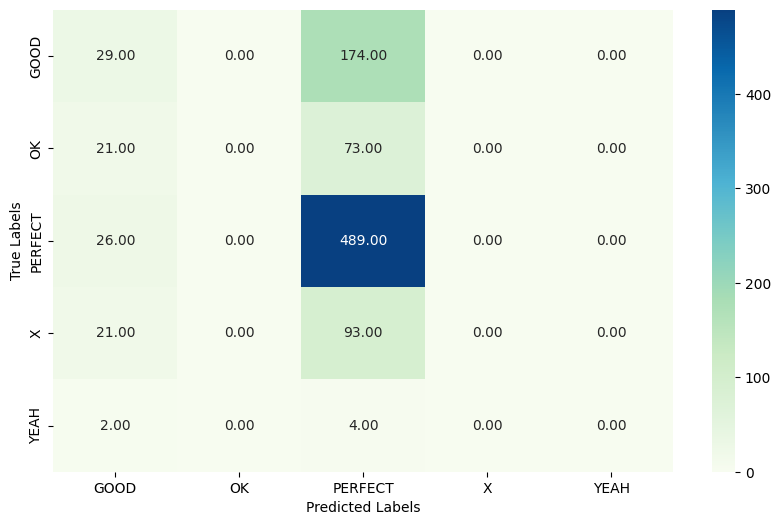

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu", xticklabels = list(label_encoder.classes_), yticklabels = list(label_encoder.classes_))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/mlp_conf.png')
plt.show()

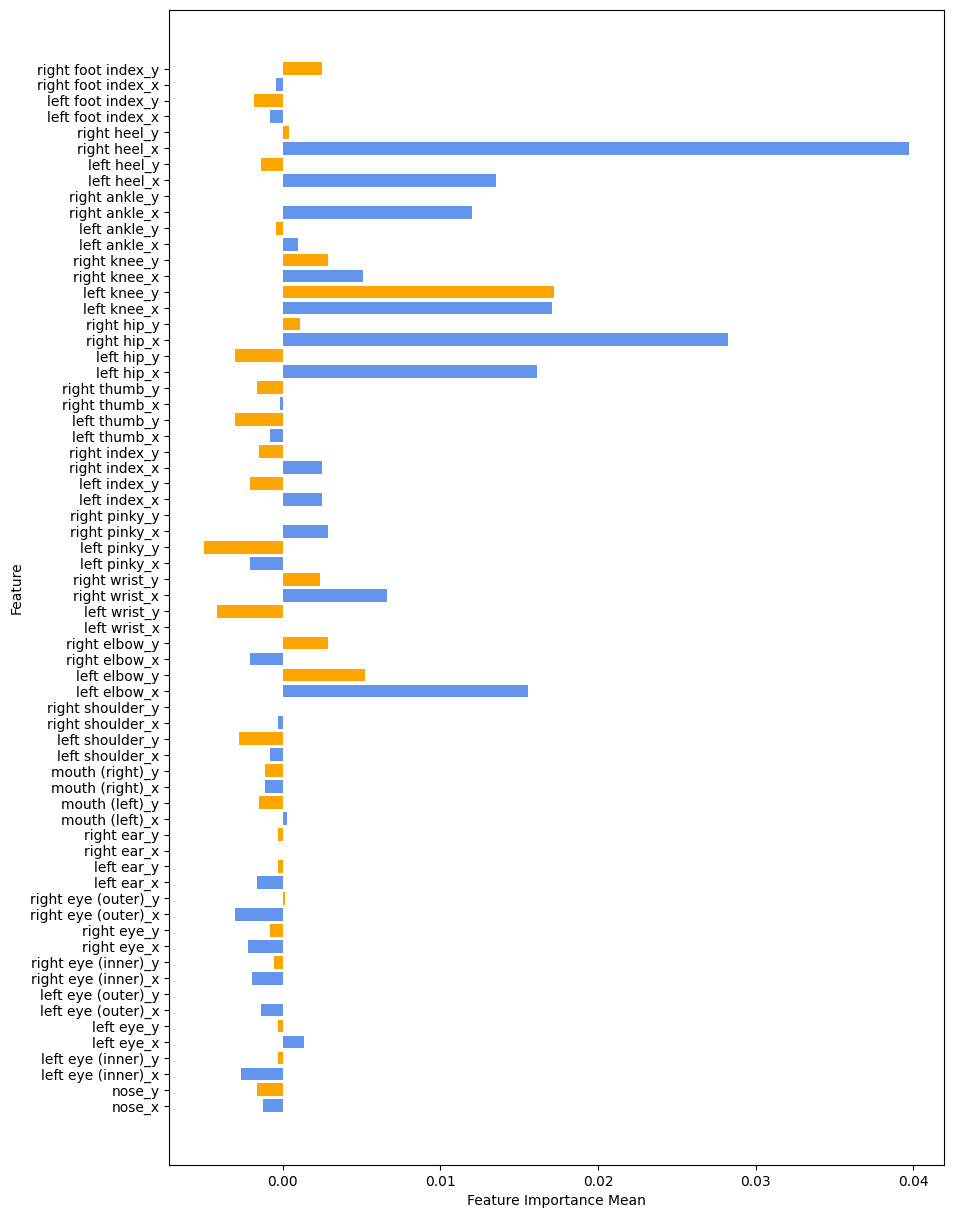

In [ ]:
from sklearn.inspection import permutation_importance

# perform permutation importance
results = permutation_importance(mlp, X_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

# plot feature importance
plt.figure(figsize=(10,15))
plt.barh([x for x in range(len(importance))], importance, linewidth=3, color=['cornflowerblue','orange'], tick_label=list(Xd.keys()))
plt.xlabel("Feature Importance Mean")
plt.ylabel("Feature")

#plt.savefig('/content/drive/MyDrive/Thesis/Results/mlp_feat.png')
plt.show()